## Imports

In [1]:
import os
import gzip
import numpy as np
import tensorflow as tf
import scipy.misc
import matplotlib.pyplot as plt
from datetime import datetime

## Configuration

In [2]:
gpu = 4
epochs = 75
batch_size = 100
image_shape = [28, 28]

learning_rate = 1e-2
regularization = 1e-4

## Data

In [3]:
def read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]

def load_train_data():
    mnist_dir = 'data/mnist/'
    train_image_path = os.path.join(mnist_dir, 'train-images-idx3-ubyte.gz')
    train_label_path = os.path.join(mnist_dir, 'train-labels-idx1-ubyte.gz')

    with gzip.open(train_image_path) as image_stream, gzip.open(train_label_path) as label_stream:
        magic_image, magic_label = read32(image_stream), read32(label_stream)
        if magic_image != 2051 or magic_label != 2049:
            raise ValueError('Invalid magic number')

        image_count, label_count = read32(image_stream), read32(label_stream)
        row_count = read32(image_stream)
        col_count = read32(image_stream)

        label_buffer = label_stream.read(label_count)
        train_labels = np.frombuffer(label_buffer, dtype=np.uint8)

        image_buffer = image_stream.read(row_count * col_count * image_count)
        train_images = np.frombuffer(image_buffer, dtype=np.uint8)
        train_images = train_images.reshape(image_count, row_count, col_count)

        return train_images, train_labels

def load_test_data():
    mnist_dir = 'data/mnist/'
    test_image_path = os.path.join(mnist_dir, 't10k-images-idx3-ubyte.gz')
    test_label_path = os.path.join(mnist_dir, 't10k-labels-idx1-ubyte.gz')

    with gzip.open(test_image_path) as image_stream, gzip.open(test_label_path) as label_stream:
        magic_image, magic_label = read32(image_stream), read32(label_stream)
        if magic_image != 2051 or magic_label != 2049:
            raise ValueError('Invalid magic number')

        image_count, label_count = read32(image_stream), read32(label_stream)
        row_count = read32(image_stream)
        col_count = read32(image_stream)

        label_buffer = label_stream.read(label_count)
        test_labels = np.frombuffer(label_buffer, dtype=np.uint8)

        image_buffer = image_stream.read(row_count * col_count * image_count)
        test_images = np.frombuffer(image_buffer, dtype=np.uint8)
        test_images = test_images.reshape(image_count, row_count, col_count)

        return test_images, test_labels
    
def normalize(images):
    '''
    Normalize the intensity values from [0, 255] into [-1, 1].
        images: Image array to normalize. Require each intensity value
                ranges from 0 to 255.
    Return normalized image array.
    '''
    return 1.0 * np.array(images) / 255 * 2.0 - 1.0

## Building models

In [4]:
def build_model(input_image, reuse):
    with tf.variable_scope('models', reuse=reuse):
        batch_size = input_image.get_shape().as_list()[0]
        
        input_image = tf.unstack(input_image, image_shape[0], 1)

        lstm_cell = tf.contrib.rnn.BasicLSTMCell(batch_size)
        
        outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, input_image, dtype=tf.float32)

        with tf.variable_scope('lstm'):
            lstm_weight = tf.get_variable(
                'lstm_weight',
                shape = [batch_size, 10],
                dtype = tf.float32,
                initializer = tf.contrib.layers.variance_scaling_initializer(),
                regularizer = tf.contrib.layers.l2_regularizer(scale=regularization)            
            )

            lstm_bias = tf.get_variable(
                'lstm_bias',
                shape = [10],
                dtype = tf.float32,
                initializer = tf.constant_initializer(0.0)
            )

            logits = tf.matmul(outputs[-1], lstm_weight) + lstm_bias
            return tf.nn.softmax(logits), logits

In [5]:
def build_train_op(batch_size, image_shape):
    [height, width] = image_shape
    batch_shape = [batch_size, height, width]
    train_image_placeholder = tf.placeholder(
        tf.float32,
        shape = batch_shape,
        name = 'train_images'
    )
    train_label_placeholder = tf.placeholder(
        tf.int32,
        shape = [batch_size, ],
        name = 'train_labels'
    )
    
    prob, logits = build_model(train_image_placeholder, False)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels = train_label_placeholder,
        logits = logits
    )
    
    
    train_step = tf.Variable(initial_value=0, trainable=False)
    prediction = tf.equal(tf.cast(tf.argmax(prob, axis=1), tf.int32), train_label_placeholder)
    train_loss = tf.reduce_mean(loss)
    train_accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

    train_vars = [x for x in tf.trainable_variables() if 'models' in x.name]
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss, global_step=train_step, var_list=train_vars)
    
    return train_image_placeholder, train_label_placeholder, train_loss, train_accuracy, train_op

In [6]:
def build_test_op(batch_size, image_shape):
    [height, width] = image_shape
    batch_shape = [batch_size, height, width]
    test_image_placeholder = tf.placeholder(
        tf.float32,
        shape = batch_shape,
        name = 'test_images'
    )
    test_label_placeholder = tf.placeholder(
        tf.int32,
        shape = [batch_size, ],
        name = 'test_labels'
    )
    
    prob, logits = build_model(test_image_placeholder, True)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels = test_label_placeholder,
        logits = logits
    )
    prediction = tf.equal(tf.cast(tf.argmax(prob, axis=1), tf.int32), test_label_placeholder)
    test_loss = tf.reduce_mean(loss)
    test_accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    
    return test_image_placeholder, test_label_placeholder, test_loss, test_accuracy

In [7]:
def main(sess):
    train_images, train_labels = load_train_data()
    test_images, test_labels = load_test_data()
    
    train_image_placeholder, train_label_placeholder, train_loss, train_accuracy, train_op = build_train_op(batch_size, image_shape)
    test_image_placeholder, test_label_placeholder, test_loss, test_accuracy = build_test_op(batch_size, image_shape)

    all_initializer_op = tf.global_variables_initializer()
    sess.run(all_initializer_op)
    
    global_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='')
    print('Global variables:')
    for i,var in enumerate(global_variables):
        print('{}, {}, {}'.format(i, var.name, var.get_shape()))
    
    train_loss_list, train_accuracy_list = [], []
    test_loss_list, test_accuracy_list = [], []
    
    for ep in range(epochs):
        shuffle = np.random.permutation(train_images.shape[0])
        
        _loss = 0.0
        _accuracy = 0.0
        for bc in range(train_images.shape[0] // batch_size):
            batch_images = normalize(train_images[shuffle[bc * batch_size : (bc + 1) * batch_size]])
            batch_labels = train_labels[shuffle[bc * batch_size : (bc + 1) * batch_size]]
            
            sess.run(train_op, feed_dict={train_image_placeholder: batch_images, 
                                          train_label_placeholder: batch_labels})
            batch_loss, batch_accuracy = sess.run([train_loss, train_accuracy],
                                                  feed_dict={train_image_placeholder: batch_images,
                                                             train_label_placeholder: batch_labels})
            _loss += batch_loss
            _accuracy += batch_accuracy
        
        _loss /= (train_images.shape[0] // batch_size)
        _accuracy /= (train_images.shape[0] // batch_size)
        train_loss_list.append(_loss)
        train_accuracy_list.append(_accuracy)
        
        if ep % 5 == 0:
            print ('Epoch {}:'.format(ep))
            print ('    Train loss {}, Train accuracy {}'.format(_loss, _accuracy))

        _loss = 0.0
        _accuracy = 0.0
        for bc in range(test_images.shape[0] // batch_size):
            batch_images = normalize(test_images[bc * batch_size : (bc + 1) * batch_size])
            batch_labels = test_labels[bc * batch_size : (bc + 1) * batch_size]

            batch_loss, batch_accuracy = sess.run([test_loss, test_accuracy],
                                                  feed_dict={test_image_placeholder: batch_images,
                                                             test_label_placeholder: batch_labels})
            _loss += batch_loss
            _accuracy += batch_accuracy
        
        _loss /= (test_images.shape[0] // batch_size)
        _accuracy /= (test_images.shape[0] // batch_size)
        test_loss_list.append(_loss)
        test_accuracy_list.append(_accuracy)
        if ep % 5 == 0:
            print ('    Test loss {}, Test accuracy {}'.format(_loss, _accuracy))
    
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

In [8]:
if __name__ == '__main__':
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True

    graph = tf.Graph()
    with graph.as_default():
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
        with tf.device('/gpu:0'):
            with tf.Session(config=config) as sess:
                with tf.variable_scope('MLP', reuse=None):
                    train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = main(sess)

Global variables:
0, MLP/models/rnn/basic_lstm_cell/kernel:0, (128, 400)
1, MLP/models/rnn/basic_lstm_cell/bias:0, (400,)
2, MLP/models/lstm/lstm_weight:0, (100, 10)
3, MLP/models/lstm/lstm_bias:0, (10,)
4, MLP/Variable:0, ()
Epoch 0:
    Train loss 1.898930761218071, Train accuracy 0.375783319119364
    Test loss 1.4175248003005982, Test accuracy 0.5641999706625939
Epoch 5:
    Train loss 0.17157128357018034, Train accuracy 0.9549333599209785
    Test loss 0.20651591196656227, Test accuracy 0.9423000234365463
Epoch 10:
    Train loss 0.08302625069084267, Train accuracy 0.9804333472251892
    Test loss 0.13275594305247068, Test accuracy 0.9611000204086304
Epoch 15:
    Train loss 0.05396210383158177, Train accuracy 0.9879500093062719
    Test loss 0.11155457233544439, Test accuracy 0.9665000182390213
Epoch 20:
    Train loss 0.04020861546508968, Train accuracy 0.9914833398660025
    Test loss 0.08000491156708449, Test accuracy 0.9770000153779983
Epoch 25:
    Train loss 0.0318315341463

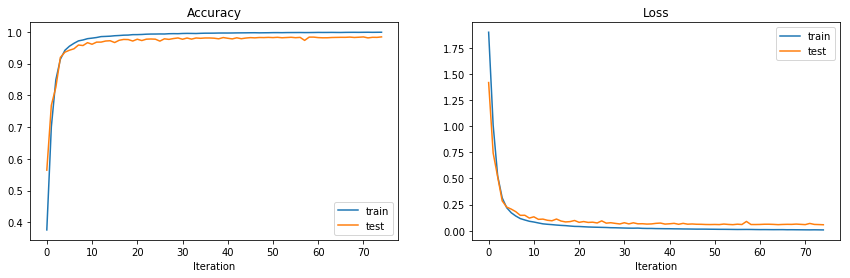

In [9]:
plt.subplots_adjust(right=2)

plt.subplot(1, 2, 1)
plt.plot(train_accuracy_list, label="train")
plt.plot(test_accuracy_list, label="test")
plt.title("Accuracy")
plt.xlabel("Iteration")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="train")
plt.plot(test_loss_list, label="test")
plt.title("Loss")
plt.xlabel("Iteration")
plt.legend(loc="best")

plt.show()